In [1]:
import os, sys, warnings, time, memory_profiler
import numpy as np, matplotlib.pyplot as plt
from sequentia import *
from tqdm.auto import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten

# Silence TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import utility functions and classes
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import *
from nn import NNClassifier

# Filter warnings
warnings.filterwarnings('ignore')

# ggplot style
plt.style.use('ggplot')

# Set seed for reproducible randomness
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

In [2]:
gestures_map = {
    'nd': 'nod',
    'mnd': 'multiple nods',
    'fu': 'face-up',
    'fd': 'face-down',
    'sh': 'shake',
    't': 'turn',
    'ti': 'tilt'
}

gestures = list(gestures_map.keys())

In [3]:
fields = ['Rx', 'Ry', 'Rz']

In [4]:
# Containers to store classifiers and results
clfs, results = {}, {'hmm': {}, 'knn': {}, 'ffnn': {}, 'lstm': {}}

In [5]:
# Load the MoCap dataset
loader = MoCapLoader(normalized=False)
X, y = loader.load(fields)

## Dataset splits

Create a stratified 65-20-15 training, validation and test set split.

In [6]:
# Create a stratified training, validation and test set split (65-20-15)
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y, (65, 20, 15), random_state=rng, stratify=True)

Training set size: 841
Validation set size: 259
Test set size: 195


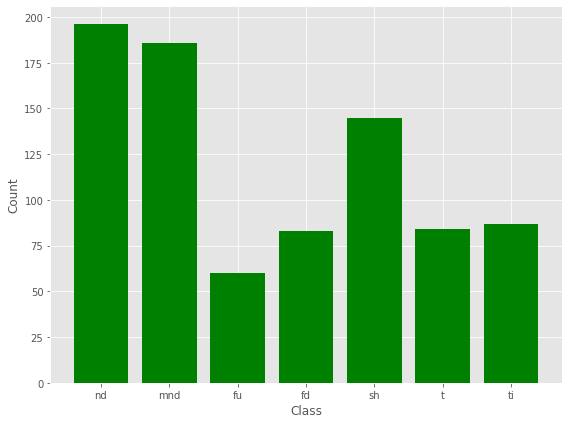

In [7]:
# MoCap dataset class counts (training set)
show_class_counts(y_train, gestures, title=None)

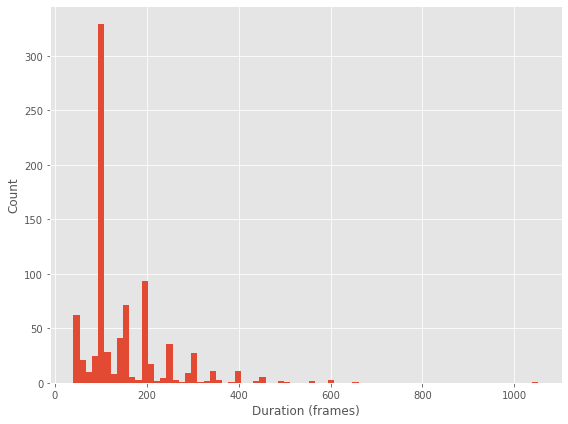

In [8]:
# Histogram of MoCap dataset gesture durations (training set)
show_durations(X_train, bins=75, title=None)

## Preprocessing

In [9]:
# Create a preprocessing pipeline
pre = Preprocess([
    Filter(window_size=10, method='median'),
    BinDownsample(bin_size=50, method='decimate'),
    Center()
])
pre.summary()

             Preprocessing summary:            
1. Filter
   Median filtering with window-size 10
-----------------------------------------------
2. BinDownsample
   Decimation bin-downsampling with bin-size 50
-----------------------------------------------
3. Center
   Centering around mean (zero mean)


In [10]:
# Function for visualizing gesture signals
def plot_gesture(gesture, label, figsize=(7, 5), same_scale=True):
    labels = ['$\\varphi^{(t)}_x$', '$\\varphi^{(t)}_y$', '$\\varphi^{(t)}_z$']
    colors = ['blue', 'red', 'green']
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=figsize)
    
    for i, ax in enumerate(axs.flat):
        ax.plot(gesture[:, i], color=colors[i])
        ax.set_ylabel(labels[i], rotation=0, labelpad=7, fontsize=14)
        if same_scale:
            pad = 0.05
            ax.set_ylim(gesture.min()-pad, gesture.max()+pad)
    ax.set_xlabel('Duration (frames)')
        
    fig.tight_layout()
#     plt.savefig('plots/example-rotation-signal.pdf')
    plt.show()

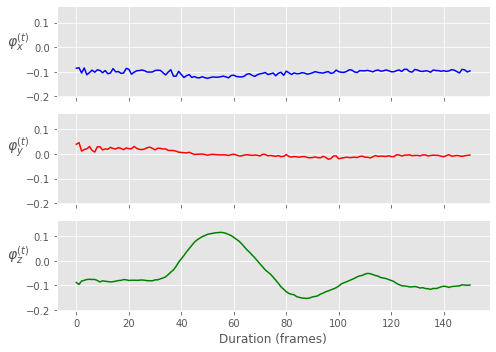

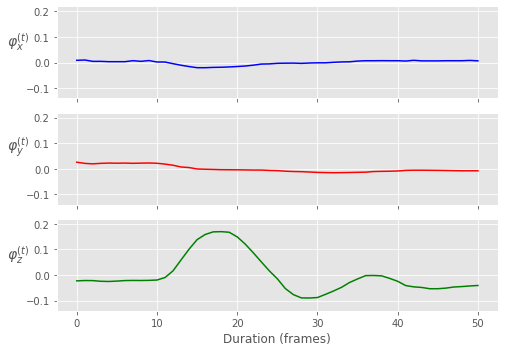

In [11]:
# Pick an example signal for visualization
x_sample, y_sample = X_train[1], y_train[1]
plot_gesture(x_sample, y_sample)
plot_gesture(pre.transform(x_sample), y_sample)

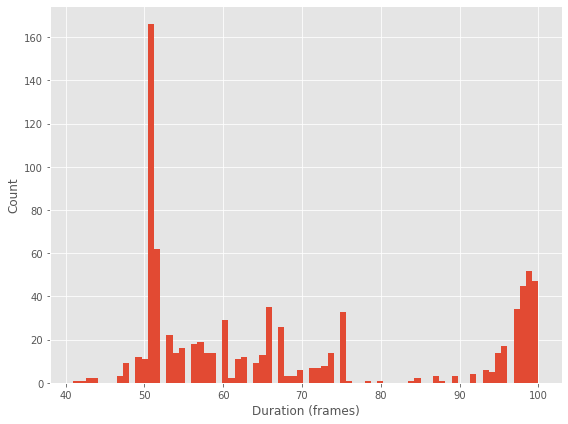

In [12]:
# Transform training data and plot histogram of MoCap dataset gesture durations (training set)
Xp_train = pre.fit_transform(X_train, verbose=True)
show_durations(Xp_train, bins=75, title=None)

In [13]:
# Apply the preprocessing pipeline to the other dataset splits
Xp_val, Xp_test = pre.transform(X_val, verbose=True), pre.transform(X_test, verbose=True)

## DTWKNN classifier

### Fitting the model

In [14]:
%%time
# Create and fit a DTWKNN classifier using the single nearest neighbor and a radius of 1
# NOTE: The radius parameter is a parameter that constrains the FastDTW algorithm.
clfs['knn'] = DTWKNN(k=1, radius=1)
clfs['knn'].fit(Xp_train, y_train)

CPU times: user 3.6 ms, sys: 2.91 ms, total: 6.51 ms
Wall time: 6.38 ms


### Evaluating the model

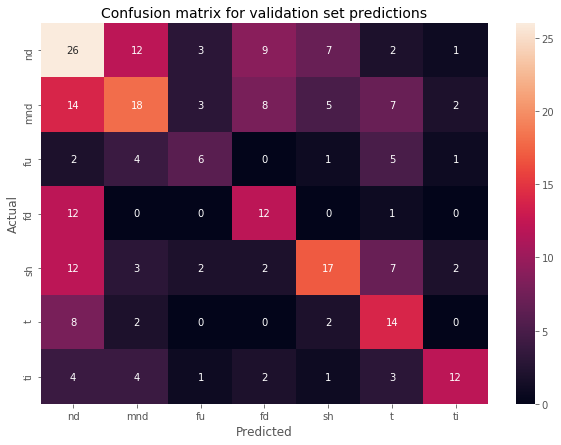

Precision: 43.66%
Recall: 41.51%
F1 score: 41.48%
Accuracy: 40.54%
CPU times: user 912 ms, sys: 450 ms, total: 1.36 s
Wall time: 1h 58s


In [15]:
%%time
results['knn']['validation'] = clfs['knn'].evaluate(Xp_val, y_val, labels=gestures, n_jobs=-1)
show_results(*results['knn']['validation'], dataset='validation', labels=gestures)

## Hidden Markov Model classifier

One gesture model $\lambda_i=(A_i,B_i,\pi_i)$ is initialized and trained for each of the gestures: `nd`, `mnd`, `sh`, `fd`, `t`, `ti`, `fu`.

### Training the model

In [16]:
%%time

# Create HMMs to represent each class
#
# NumPy sometimes raises some errors as a result of instability during the Cholesky decomposition.
# According to issue #414 on Pomegranate's GitHub repository, this may be caused by:
# - Too many states in the HMMs
# - Too many dimensions in the input data, which leads to a large covariance matrix
# - Too few training examples
hmms = []
for g in tqdm(gestures, desc='Training HMMs'):
    hmm = HMM(label=g, n_states=8, random_state=rng)
    hmm.set_random_initial()
    hmm.set_random_transitions()
    hmm.fit([Xp_train[i] for i, label in enumerate(y_train) if label == g])
    hmms.append(hmm)
    
# Fit a HMM classifier with the HMMs
clfs['hmm'] = HMMClassifier()
clfs['hmm'].fit(hmms)


CPU times: user 1min 5s, sys: 380 ms, total: 1min 5s
Wall time: 1min 10s


### Evaluating the model

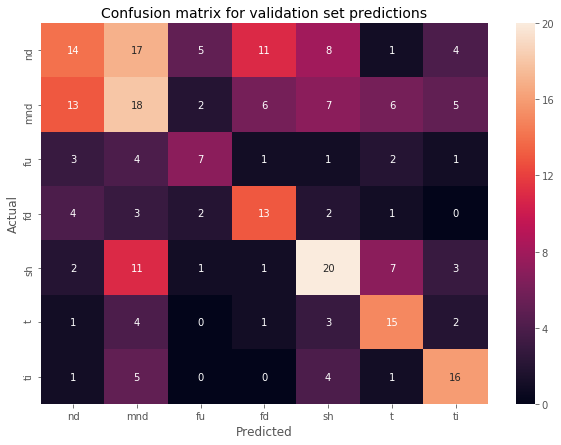

Precision: 41.14%
Recall: 43.59%
F1 score: 41.86%
Accuracy: 39.77%
CPU times: user 1.09 s, sys: 44.9 ms, total: 1.13 s
Wall time: 1.05 s


In [17]:
%%time
results['hmm']['validation'] = clfs['hmm'].evaluate(Xp_val, y_val, labels=gestures)
show_results(*results['hmm']['validation'], dataset='validation', labels=gestures)

In [18]:
with np.printoptions(precision=3, suppress=True):
    display(hmms[0].initial)
    display(hmms[0].transitions)

array([0.312, 0.251, 0.13 , 0.124, 0.025, 0.02 , 0.   , 0.138])

array([[0.958, 0.031, 0.005, 0.001, 0.006, 0.   , 0.   , 0.   ],
       [0.   , 0.977, 0.006, 0.009, 0.003, 0.001, 0.001, 0.004],
       [0.   , 0.   , 0.967, 0.027, 0.005, 0.   , 0.001, 0.   ],
       [0.   , 0.   , 0.   , 0.964, 0.002, 0.001, 0.026, 0.008],
       [0.   , 0.   , 0.   , 0.   , 0.986, 0.008, 0.006, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.99 , 0.01 , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.997, 0.003],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ]])

## Feedforward Neural Network classifier

### Fitting the model

In [19]:
%%time
clfs['ffnn'] = NNClassifier(epochs=114, batch_size=128, optimizer=Adam(learning_rate=0.002), classes=gestures)
hist = clfs['ffnn'].fit([
        Flatten(),
        Dense(300, activation='relu'),
        Dropout(0.5),
        Dense(300, activation='relu'),
        Dropout(0.5),
        Dense(len(gestures), activation='softmax')
    ], 
    Xp_train, y_train, validation_data=(Xp_val, y_val), verbose=1, return_history=True, early_stop=False
)

CPU times: user 10.7 s, sys: 1.37 s, total: 12.1 s
Wall time: 9.2 s


In [20]:
# Summarize the model
clfs['ffnn'].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  90300     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  90300     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  2107      
Total params: 182,707
Trainable params: 182,707
Non-trainable params: 0
__________________________________________________

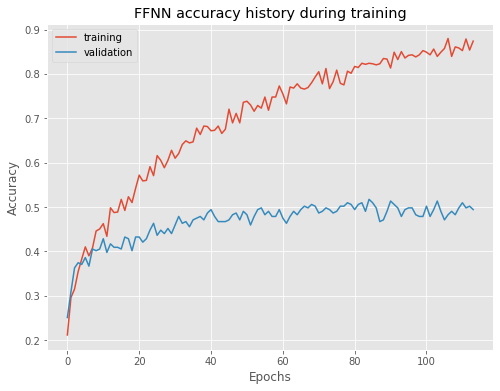

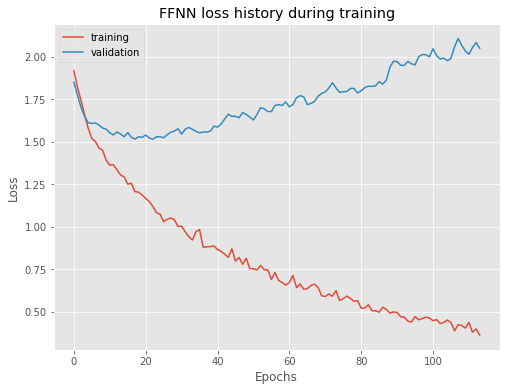

In [21]:
# Display accuracy and loss history during training
show_accuracy_history('FFNN', hist)
show_loss_history('FFNN', hist)

### Evaluating the model

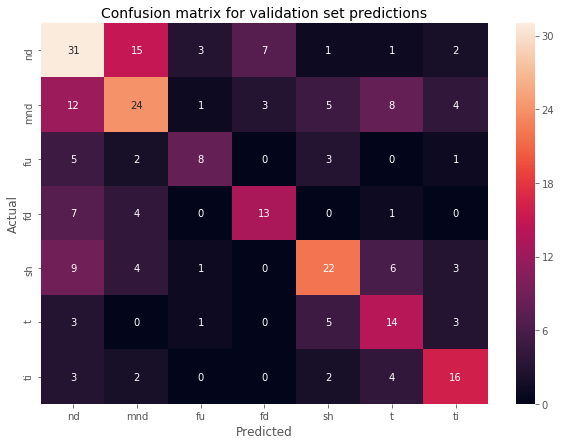

Precision: 51.32%
Recall: 49.98%
F1 score: 50.23%
Accuracy: 49.42%
CPU times: user 670 ms, sys: 43.7 ms, total: 713 ms
Wall time: 650 ms


In [22]:
%%time
results['ffnn']['validation'] = clfs['ffnn'].evaluate(Xp_val, y_val)
show_results(*results['ffnn']['validation'], dataset='validation', labels=gestures)

## LSTM classifier

### Fitting the model

In [23]:
%%time
clfs['lstm'] = NNClassifier(epochs=175, batch_size=128, optimizer=Adam(learning_rate=0.002), classes=gestures)
hist = clfs['lstm'].fit([
    Bidirectional(LSTM(300, return_sequences=True, recurrent_dropout=0.5)),
    Bidirectional(LSTM(300, recurrent_dropout=0.5)),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(len(gestures), activation='softmax')
], Xp_train, y_train, validation_data=(Xp_val, y_val), return_history=True, verbose=1, early_stop=False)

CPU times: user 3h 52min 29s, sys: 57min 13s, total: 4h 49min 43s
Wall time: 2h 14min 22s


In [24]:
# Summarize the model
clfs['lstm'].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  729600    
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  2162400   
_________________________________________________________________
dense_3 (Dense)              multiple                  60100     
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  707       
Total params: 2,952,807
Trainable params: 2,952,807
Non-trainable params: 0
_________________________________________________________________


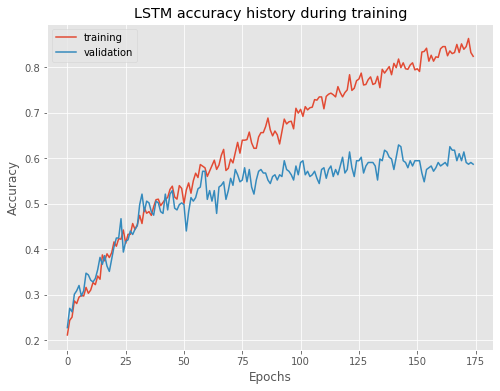

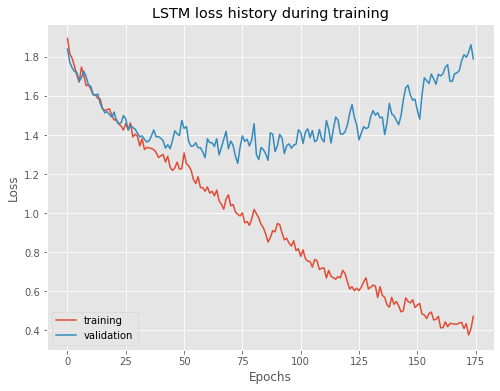

In [25]:
# Display accuracy and loss history during training
show_accuracy_history('LSTM', hist)
show_loss_history('LSTM', hist)

### Evaluating the model

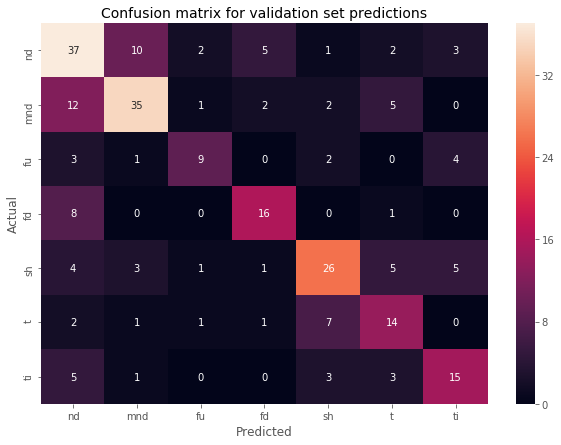

Precision: 59.24%
Recall: 57.37%
F1 score: 57.98%
Accuracy: 58.69%
CPU times: user 15.7 s, sys: 2.28 s, total: 18 s
Wall time: 9.73 s


In [26]:
%%time
results['lstm']['validation'] = clfs['lstm'].evaluate(Xp_val, y_val)
show_results(*results['lstm']['validation'], dataset='validation', labels=gestures)

# Hyper-parameter searches

## HMM

## DTWKNN

### Radius parameter

### Neighborhood parameter ($k$)

## FFNN

## LSTM

# Test results

## DTWKNN

## HMM

## FFNN

## LSTM

# Preprocessing experiments

## Filtering

## Downsampling (standard)

## Downsampling (bin)